In [1]:
import os
from pathlib import Path

import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from dotenv import load_dotenv

from utils.shortcut import quick_get_roi, get_fake_result
from utils.yolo import get_teeth_ROI

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

%matplotlib inline



/opt/miniconda3/envs/pt113/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
model_path = Path(os.getenv('YOLO_MODEL_DIR')) / '8-bound.pt'
model = torch.hub.load(r'..\YOLO', 'custom', path=model_path, source='local') if model_path.is_file() else None
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'
data_dir


PosixPath('/Users/lucyxu/PycharmProjects/datasets/phase-2')

In [3]:
image_paths = list(data_dir.glob('00008026.jpg'))
image_path = image_paths[0]
image_name = image_path

image_path.name


'00008026.jpg'

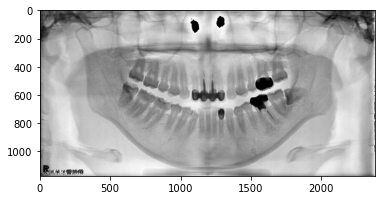

In [10]:
im = cv.imread(str(image_path), cv.IMREAD_GRAYSCALE)

plt.gray()
plt.imshow(1 - im)
plt.show()


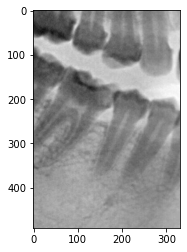

In [11]:
source, flag, tooth_position, teeth_roi_split_teeth, target_roi = quick_get_roi(image_path, roi_index=3)
teeth_roi_split_teeth = teeth_roi_split_teeth[image_path.stem]

# margin = 50
plt.gray()
plt.imshow(1 - source)

plt.show()


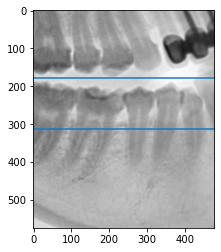

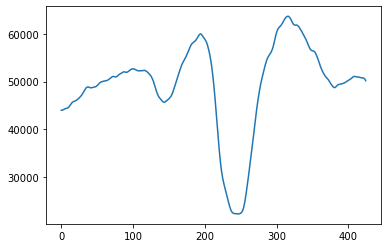

In [17]:
from scipy import ndimage, special
from utils.edge import get_rotation_angle, gum_jaw_separation, fill_rotate

theta = get_rotation_angle(source, flag=flag, tooth_position=tooth_position)
source_rotated = fill_rotate(im, target_roi['xyxy'], theta)
# source_rotated = ndimage.rotate(source, theta, reshape=True, cval=255)

gum_sep_line, jaw_sep_line, hor_valleys, hor = gum_jaw_separation(source_rotated, flag=flag)

height, width = source.shape
phi = np.radians(abs(theta))
opposite = np.sin(phi) * width
adjacent = np.cos(phi) * height

if flag == 'upper':
    y1 = gum_sep_line
    y2 = jaw_sep_line
elif flag == 'lower':
    y1 = jaw_sep_line
    y2 = gum_sep_line
else:
    raise ValueError(f'flag only accept upper or lower but get {flag}.')

source_roi = source_rotated[y1:y2, :]

t = np.tan(phi)
left_padding, right_padding = 0, 1
if theta > 0:
    left_padding = round((y2 - opposite) * t)
    right_padding = round((adjacent - y1) * t)
elif theta < 0:
    left_padding = round((adjacent - y1) * t)
    right_padding = round((y2 - opposite) * t)
source_roi = source_roi[:, left_padding:-right_padding]

plt.imshow(1 - source_rotated)
plt.axhline(gum_sep_line)
plt.axhline(jaw_sep_line)
plt.show()

plt.plot(hor)
plt.show()


In [6]:
roi_index = 3
tooth_position_dict = {
    0: 'left',
    1: 'middle',
    2: 'right'

}
filename = image_name.stem

if model:
    results = model(image_name)
else:
    results = get_fake_result(image_name)

teeth_roi = get_teeth_ROI(results)
teeth_roi_images = teeth_roi['images'][filename]
teeth_roi_split_teeth = teeth_roi['split_teeth']

target_roi = teeth_roi_images[roi_index]
target_roi_image = target_roi['image']
flag = target_roi['flag']
tooth_position = target_roi['tooth_position']
im_g = cv.cvtColor(target_roi_image, cv.COLOR_RGBA2GRAY)
im_g_shape = np.array(np.array(im_g.shape)[[1, 0]])

teeth_roi_images[3]['xyxy']



tensor([ 749,  484, 1080,  975], dtype=torch.int32)

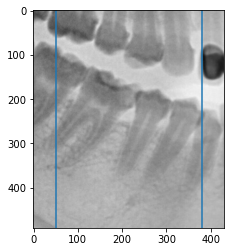

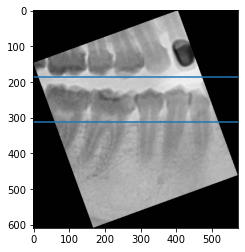

In [7]:
im = cv.imread(image_path)
x1, y1, x2, y2 = teeth_roi_images[3]['xyxy'].clone()

x1 -= 50
x2 += 50

im_region = im[y1:y2, x1:x2]
im_rotated = ndimage.rotate(im_region, theta)

h, w, *_ = im_region.shape
s, c, t = special.sindg(theta), special.cosdg(theta), special.tandg(theta)

offset_left = (gum_sep_line - w * s) * t
offset_right = (h * c - gum_sep_line) * t

plt.imshow(1 - im_region)

plt.axvline(50)
plt.axvline(w - 50)


plt.show()

plt.imshow(1 - im_rotated)

# plt.axvline(50 + offset_left)
# plt.axvline(w - 50 + offset_left)

plt.axhline(gum_sep_line)
plt.axhline(jaw_sep_line)

plt.show()


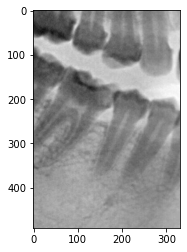

In [8]:


plt.imshow(1 - im_g)
plt.show()
